# Implementation of the CNN 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
from scipy.stats import loguniform, gamma, uniform
import time 
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import pickle
from scipy.integrate import simpson
from scipy import interpolate, integrate

2023-06-28 13:24:18.957966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Function to load/save data
def full_pickle(title, data):
 pikd = open(title + '.pickle', 'wb')
 pickle.dump(data, pikd)
 pikd.close()

def loosen(file):
 pikd = open(file, 'rb')
 data = pickle.load(pikd)
 pikd.close()
 return data


#Create metrics for trainning
from tensorflow.keras import backend as K

def precision_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    predicted_positives = K.sum( K.round(K.clip(y_pred,0,1)) )
    return true_positives / ( predicted_positives + K.epsilon())

def recall_m(y_true, y_pred):
    true_positives = K.sum( K.round(K.clip(y_true*y_pred,0,1)) )
    real_positives = K.sum( K.round(K.clip(y_true,0,1)) )
    return true_positives / (real_positives + K.epsilon())

def f_score(y_true, y_pred):
    P = precision_m(y_true, y_pred)
    R = recall_m(y_true, y_pred)
    return (2*P*R) / (P+R+K.epsilon())

#Evaluation for binary classification
def evaluate(y_pred, label): 

    index_n = np.where(label == 0)[0]
    index_p = np.where(label == 1)[0]

    true_positif = (y_pred[index_p] == 1).sum()
    false_positif = (y_pred[index_n] == 1).sum()

    true_negatif = (y_pred[index_n] == 0).sum()
    false_negatif = (y_pred[index_p] == 0).sum()

    m = np.array([
        [true_negatif, false_positif],
        [false_negatif, true_positif]
    ])
    
    precision = true_positif/(true_positif + false_positif + K.epsilon())
    recall = true_positif/(true_positif + false_negatif + K.epsilon())
    f_score = (2*precision*recall)/(precision+recall + K.epsilon())
    
    return precision, recall,f_score, m


In [3]:
#Load dataset 1 for the neural network

X_LS = np.load('./data/set1/X_LS.npy',allow_pickle = True)
X_max_values = np.load('./data/set1/X_max_values.npy',allow_pickle = True)
Y = np.load('./data/set1/Y.npy',allow_pickle = True)
freq = np.load('./data/set1/Freq.npy',allow_pickle = True)

In [4]:
N_data = len(X_LS)
print("X_lS : ", len(X_LS), type(X_LS))
print("X_max_values : ", len(X_max_values), type(X_max_values))

print("\n1 periodogramme : ",len(X_LS[0]), type(X_LS[0]) ) #periodogramme
print("1 max values : ", len(X_max_values[0]), type(X_max_values[0]) ) #max values 

print("Y : ", len(Y), type(Y))

X_lS :  13704 <class 'numpy.ndarray'>
X_max_values :  13704 <class 'numpy.ndarray'>

1 periodogramme :  990 <class 'numpy.ndarray'>
1 max values :  2 <class 'numpy.ndarray'>
Y :  13704 <class 'numpy.ndarray'>


In [5]:
#Data pre-processing 
#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)
#Periodogramme
X_shape =  [N_data,len(X_LS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_LS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )
#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))
#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))
#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train1, X_val1 = X1[0:split, :, :], X1[split:, :, :]
X_train2,X_val2 = X2[0:split, :, :], X2[split:, :, :]
Y_train, Y_val = Y[0:split], Y[split:,:]

print("Periodogramme train size : ", X_train1.shape)
print("Periodogramme validation size : ", X_val1.shape,"\n")
print("Max_values train size : ", X_train2.shape)
print("Max_values validation size : ", X_val2.shape,"\n")
print("Label train size : ", Y_train.shape)
print("Label validation size : ", Y_val.shape)

Periodogramme train size :  (10963, 990, 1)
Periodogramme validation size :  (2741, 990, 1) 

Max_values train size :  (10963, 2, 1)
Max_values validation size :  (2741, 2, 1) 

Label train size :  (10963, 1)
Label validation size :  (2741, 1)


2023-06-28 13:24:25.495224: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
#Model with functional API Keras
#periodogramme as input to a CNN
inputs1 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,1))(inputs1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2)
outputs2 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1, outputs2])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

In [7]:
model = tf.keras.Model(inputs=[inputs1,inputs2], outputs=outputs, name ="ExoplANNET")
model.summary()

Model: "ExoplANNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 990, 32)      96          ['input_1[0][0]']                
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 495, 32)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 495, 32)      6176        ['max_pooling1d[0][0]']          
                                                                                         

In [8]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model.evaluate( x = [X_train1, X_train2], y = Y_train, batch_size = 128)

86/86 [==============================] - 5s 49ms/step - loss: 0.6942 - binary_accuracy: 0.2298 - precision_m: 0.1212 - recall_m: 0.0861 - f_score: 0.0997


In [10]:
#Train the network
start = time.time()
history = model.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val1,X_val2], Y_val))                                                      
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 13s 132ms/step - loss: 0.6573 - binary_accuracy: 0.7095 - precision_m: 0.7922 - recall_m: 0.6069 - f_score: 0.6735 - val_loss: 0.5304 - val_binary_accuracy: 0.7709 - val_precision_m: 0.8702 - val_recall_m: 0.6271 - val_f_score: 0.7264
Epoch 2/50
86/86 [==============================] - 11s 132ms/step - loss: 0.4809 - binary_accuracy: 0.7860 - precision_m: 0.8225 - recall_m: 0.7314 - f_score: 0.7720 - val_loss: 0.4375 - val_binary_accuracy: 0.8034 - val_precision_m: 0.8424 - val_recall_m: 0.7400 - val_f_score: 0.7860
Epoch 3/50
86/86 [==============================] - 11s 129ms/step - loss: 0.4562 - binary_accuracy: 0.7971 - precision_m: 0.8185 - recall_m: 0.7677 - f_score: 0.7905 - val_loss: 0.4215 - val_binary_accuracy: 0.8128 - val_precision_m: 0.8337 - val_recall_m: 0.7711 - val_f_score: 0.7992
Epoch 4/50
86/86 [==============================] - 11s 128ms/step - loss: 0.4437 - binary_accuracy: 0.8058 - precision_m: 0.8184 - recall_

Temps d'entrainement :  244.95464396476746 s


Text(0.5, 0, 'Epochs')

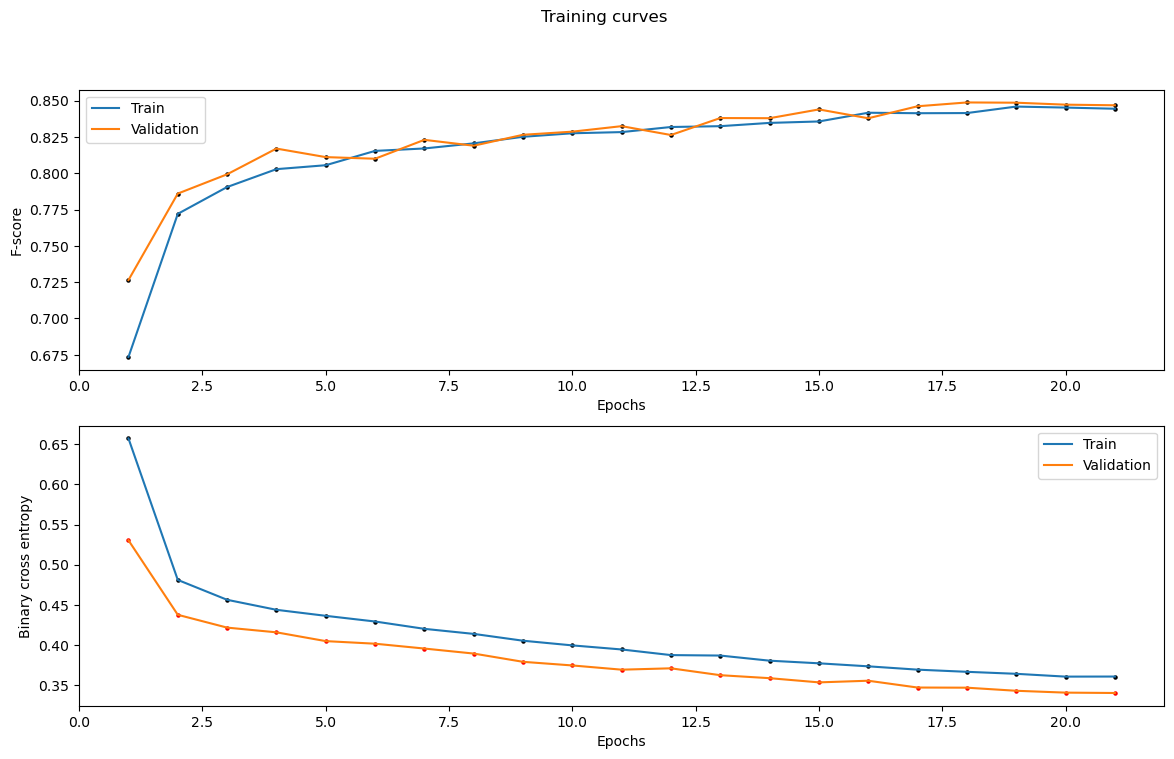

In [11]:
print("Temps d'entrainement : ", time_train, "s")

x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [12]:
#data set 2 test for testing

X_LS_test = np.load('./data/set2/X_LS.npy', allow_pickle=True)
X_max_values_test = np.load('./data/set2/X_max_values.npy', allow_pickle=True)
Y_test = np.load('./data/set2/Y.npy', allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X1_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X2_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X1_test.shape)
print("X2_test shape : ", X2_test.shape)
print("label_test shape : ", label_test.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


In [13]:
#Evaluation with samples from dataset2
y_pred_cnn1 = model.predict( x =[X1_test, X2_test])

313/313 [==============================] - 14s 43ms/step


Best F-score achieve by CNN =  0.774  with threshold =  0.664
Confusion matrix :  [[6320  704]
 [ 653 2323]]


Text(0, 0.5, 'Pdet')

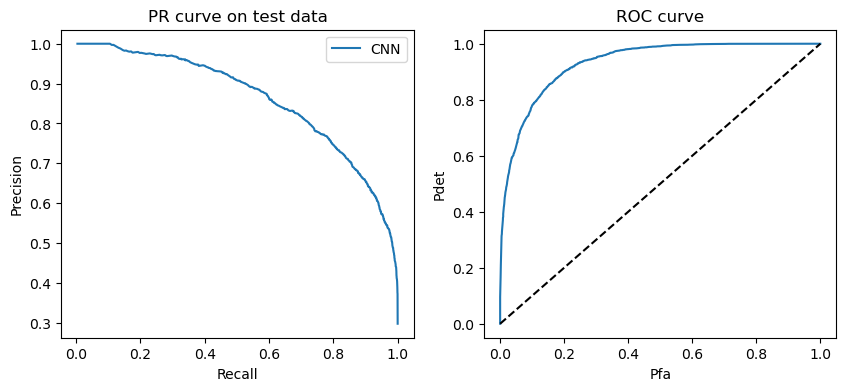

In [14]:
N = 1000
threshold = np.linspace(np.min(y_pred_cnn1),np.max(y_pred_cnn1),N)
P = np.zeros(N)
R = np.zeros(N)
Pdet = np.zeros(N)
Pfa = np.zeros(N)

best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,label_test) 
    Pdet[i], Pfa[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m
        
    
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curve on test data")
plt.plot(R[:-1],P[:-1], label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.subplot(122)
plt.title("ROC curve")
plt.plot(Pfa, Pdet)
plt.plot(np.linspace(0,1,N), np.linspace(0,1,N), '--', c ='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

<Figure size 800x400 with 0 Axes>

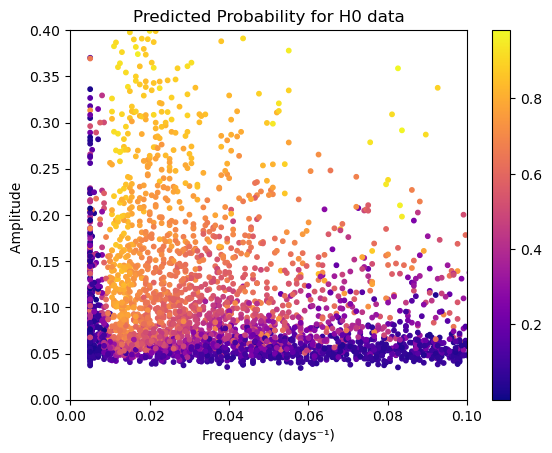

In [100]:
# Color map
ind_H0 = np.where(label_test == 0)[0]
output_H0 = y_pred_cnn1[ind_H0]
freq_H0, amp_H0 = X2_test.numpy()[ind_H0,0,:], X2_test.numpy()[ind_H0,1,:]

plt.figure(figsize=(8,4))
f, ax = plt.subplots()
plt.title("Predicted Probability for H0 data")
plot = plt.scatter(freq_H0, amp_H0, s = 10,c = output_H0, cmap='plasma')
f.colorbar(plot)
plt.xlim(0,0.1)
plt.ylim(0,0.4)
plt.xlabel("Frequency (days⁻¹)")
plt.ylabel("Amplitude ")
plt.savefig("./../../Pictures/colomor_mapHO.png")

<Figure size 800x400 with 0 Axes>

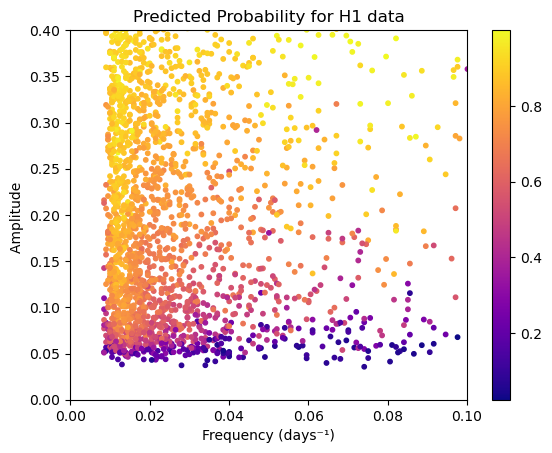

In [99]:
# Color map H1
ind_H1 = np.where(label_test == 1)[0]
output_H1 = y_pred_cnn1[ind_H1]
freq_H1, amp_H1 = X2_test.numpy()[ind_H1,0,:], X2_test.numpy()[ind_H1,1,:]

plt.figure(figsize=(8,4))
f, ax = plt.subplots()
plt.title("Predicted Probability for H1 data")
plot = plt.scatter(freq_H1, amp_H1, s = 10,c = output_H1, cmap='plasma')
f.colorbar(plot)
plt.xlim(0,0.1)
plt.ylim(0,0.4)
plt.xlabel("Frequency (days⁻¹)")
plt.ylabel("Amplitude ")
plt.savefig("./../../Pictures/colomor_mapH1.png")

In [72]:
#Test with data from Nieto papers
labels_test= []
LS_test = []
max_value_test =[]

for filename in np.sort(os.listdir("../Git_article/ExoplANNET/data")):
    
    if filename.endswith(".npy") :
        
        if filename.startswith("pe"): 
             LS_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("l"): 
             labels_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))
        if filename.startswith("po"): 
             max_value_test.append(np.load('../Git_article/ExoplANNET/data/' + filename))

                
#Concatenate arrays
labels_p = np.concatenate((labels_test[0][:],labels_test[1][:],labels_test[2][:],labels_test[3][:],labels_test[4][:]))
LSs_p = np.concatenate((LS_test[0][:], LS_test[1][:],LS_test[2][:],LS_test[3][:],LS_test[4][:]))
max_values_p = np.concatenate((max_value_test[0][:],max_value_test[1][:],max_value_test[2][:],max_value_test[3][:],max_value_test[4][:]) ) 

#Shuffle
c = list(zip(LSs_p, max_values_p,labels_p))
random.shuffle(c)
LSs_p, max_values_p,labels_p = zip(*c)

for i in range(len(max_values_p)):
    max_values_p[i][0] = freq[round(max_values_p[i][0])]

#Convert to tensor
X1_p = tf.convert_to_tensor(LSs_p, dtype= 'float32')
X_p_shape =  [len(LSs_p),len(X_LS[0]), 1]
X1_p = tf.reshape(X1_p, X_p_shape )

#Max values
X2_p = tf.convert_to_tensor(max_values_p, dtype= 'float32')
X2_p = tf.reshape(X2_p, (len(LSs_p), 2,1))

#Label
Y_p = tf.convert_to_tensor(labels_p)
Y_p = tf.reshape(Y_p, (len(LSs_p),1 ))


print("X1_test shape : ", X1_p.shape)
print("X2_test shape : ", X2_p.shape)
print("Y_test shape : ", Y_p.shape)

X1_test shape :  (20000, 990, 1)
X2_test shape :  (20000, 2, 1)
Y_test shape :  (20000, 1)


In [73]:
#Evaluation
y_pred = model.predict( x =[X1_p, X2_p])

625/625 [==============================] - 29s 46ms/step


Best F-score achieve by CNN =  0.748  with threshold =  0.648
Confusion matrix :  [[14790   797]
 [ 1302  3111]]


Text(0, 0.5, 'Pdet')

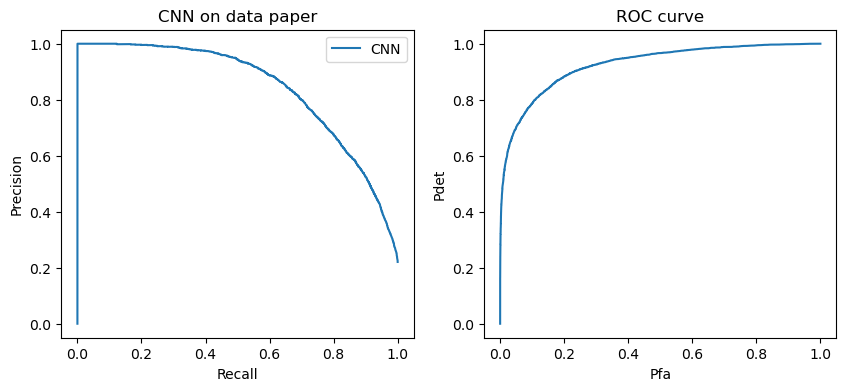

In [74]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P, R = np.zeros(N),np.zeros(N)
Pdet, Pfa = np.zeros(N),np.zeros(N)

best_score = 0

for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p)
    Pdet[i], Pfa[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1]) 
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

        
print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("CNN on data paper")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.subplot(122)
plt.title("ROC curve")
plt.plot(Pfa, Pdet)
plt.xlabel("Pfa")
plt.ylabel("Pdet")

# Paper model

In [75]:
model_paper = tf.keras.models.load_model("./../Git_article/ExoplANNET/exoplANNET_trained.h5")

In [76]:
y_pred = model_paper.predict( x =[X1_p, X2_p])

625/625 [==============================] - 36s 57ms/step


Best F-score achieve by CNN =  0.798  with threshold =  0.529
Confusion matrix :  [[14969   618]
 [ 1071  3342]]


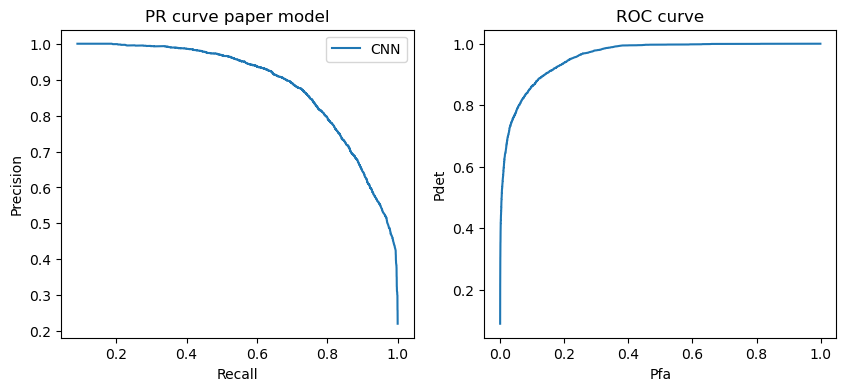

In [77]:
N = 10000
threshold = np.linspace(0.0001,0.9999,N)
P,R = np.zeros(N), np.zeros(N)
Pdet,Pfa = np.zeros(N), np.zeros(N)

best_score = 0
for i in range(N):
    y_seuil = np.where(y_pred > threshold[i],1,0)
    P[i] ,R[i],f,m = evaluate(y_seuil,Y_p)
    Pdet[i], Pfa[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score) : best_score, best_threshold, best_m = f, threshold[i], m

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curve paper model")
plt.plot(R,P, label='CNN'),  plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.subplot(122)
plt.title("ROC curve")
plt.plot(Pfa, Pdet)
plt.xlabel("Pfa")
plt.ylabel("Pdet")

print("Best F-score achieve by CNN = ", round(best_score,3), " with threshold = ",round(best_threshold,3) )
print("Confusion matrix : ", best_m)

# Comparaison with others methods
### 1) FAP

In [98]:
pdf_mean = np.load('./data/set1/pdf_mean.npy',allow_pickle = True)

Text(0.5, 0, 'Max amplitude')

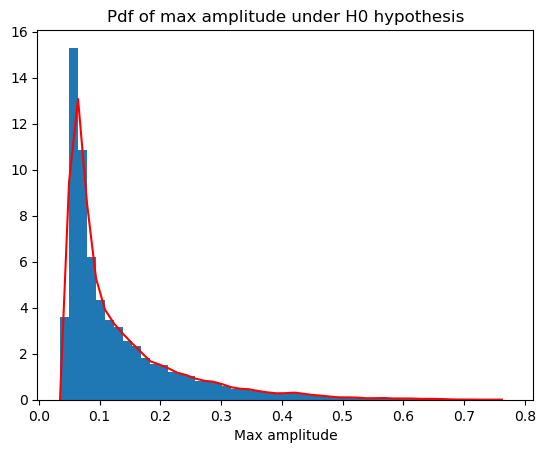

In [99]:
mean_bin = np.zeros(pdf_mean[1].shape[0]-1)
for i in range(pdf_mean[1].shape[0]-1) : mean_bin[i] = (pdf_mean[1][i+1] + pdf_mean[1][i])/2
f_pdf = interpolate.interp1d(mean_bin, pdf_mean[0],bounds_error = False, fill_value = (0,0))

plt.title("Pdf of max amplitude under H0 hypothesis")
plt.bar(pdf_mean[1][:-1], pdf_mean[0], width=np.diff(pdf_mean[1]), align='edge')
plt.plot(pdf_mean[1][:-1], f_pdf(pdf_mean[1][:-1]), c ='r')
plt.xlabel("Max amplitude")

In [100]:
# Function to compute the p-value of a distribution
def compute_p_value( pdf, xi):
    cdf = np.cumsum(pdf[0]*np.diff(pdf[1]))
    mean_bin = np.zeros(pdf[1].shape[0]-1)
    for i in range(pdf[1].shape[0]-1) : mean_bin[i] = (pdf[1][i+1] + pdf[1][i])/2
    f_cdf = interpolate.interp1d(mean_bin, cdf,bounds_error = False, fill_value = (0,1))
    p_value = 1 - f_cdf(xi)
    return p_value

In [101]:
# Predict label with FAP method
def predict_FAP(Maxs, pdf_mean):
    N_test = Maxs.shape[0]
    p_vals = np.zeros(N_test)
    for i in range(N_test):
        p_vals[i] = compute_p_value(pdf_mean,Maxs[i][1])[0]
    return p_vals

In [102]:
y_pred_FAP = predict_FAP(X2_test, pdf_mean)

/tmp/ipykernel_24414/4196186778.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_24414/4196186778.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN =  0.77  with threshold =  0.669
Confusion matrix : 
 [[6182  842]
 [ 587 2389]]
AUC =  0.851

Best F-score achieve by FAP =  0.728  with threshold =  0.372
Confusion matrix : 
 [[5947 1077]
 [ 654 2322]]
AUC =  0.822


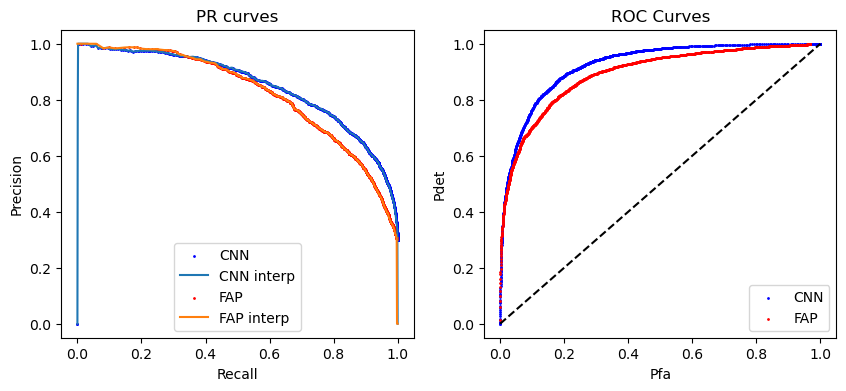

In [103]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
False_neg, False_pos = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)
best_score_fap = 0
best_score_cnn = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    False_pos[i],False_neg[i] = m[0][1], m[1][0]
    if (f > best_score_cnn) : best_score_cnn, best_threshold_cnn, best_m_cnn = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1,P1, label ='CNN',s = 1, c ='b'), plt.legend()
plt.plot(x_interp,f1(x_interp),label='CNN interp'),plt.legend()
plt.scatter(R2,P2, label='FAP',s = 1, c ='r'),  plt.legend()
plt.plot(x_interp,f2(x_interp),label='FAP interp'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1, label='CNN', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label='FAP', s=1, c='r'),plt.legend()
plt.plot(x_interp, x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")

print("\nBest F-score achieve by CNN = ", round(best_score_cnn,3), " with threshold = ",round(best_threshold_cnn,3) )
print("Confusion matrix : \n", best_m_cnn)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))

In [104]:
y_cnn_H0 = y_pred_cnn1[np.where(label_test == 0)[0]]
y_cnn_H1 = y_pred_cnn1[np.where(label_test == 1)[0]]
dist_cnn_H0 = np.histogram(y_cnn_H0, bins = 50, density = True)
dist_cnn_H1 = np.histogram(y_cnn_H1, bins = 50, density = True)

y_fap_H0 = 1-y_pred_FAP[np.where(label_test == 0)[0]]
y_fap_H1 = 1-y_pred_FAP[np.where(label_test == 1)[0]]
dist_fap_H0 = np.histogram(y_fap_H0, bins = 50, density = True)
dist_fap_H1 = np.histogram(y_fap_H1, bins = 50, density = True)

Text(0, 0.5, 'Density')

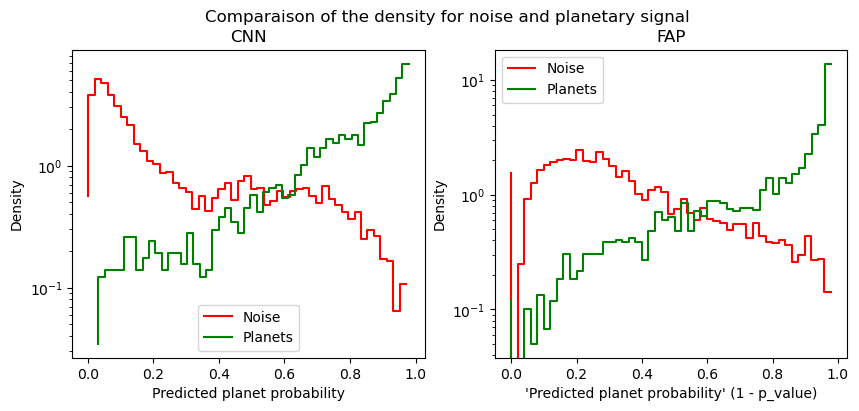

In [105]:
plt.figure(figsize = (10,4))
plt.suptitle("Comparaison of the density for noise and planetary signal")
plt.subplot(121)
plt.title("CNN")
plt.step(dist_cnn_H0[1][:-1], dist_cnn_H0[0], color="red", label="Noise"), plt.legend()
plt.step(dist_cnn_H1[1][:-1], dist_cnn_H1[0],color= 'green', label ='Planets'),plt.legend()
plt.yscale('log')
plt.xlabel("Predicted planet probability")
plt.ylabel("Density")

plt.subplot(122)
plt.title("FAP")
plt.step(dist_fap_H0[1][:-1], dist_fap_H0[0], color="red", label="Noise"), plt.legend()
plt.step(dist_fap_H1[1][:-1], dist_fap_H1[0],color= 'green', label ='Planets'), plt.legend()
plt.yscale('log')
plt.xlabel("'Predicted planet probability' (1 - p_value)")
plt.ylabel("Density")

### Define threshold for the CNN

In [106]:
#Reference with FAP method with p-value of 0.05
threshold_fap = 0.4
y_seuil = np.where(y_pred_FAP < threshold_fap ,1,0)
p,r,f,m = evaluate(y_seuil,label_test)
false_pos_fap = m[0][1]
false_neg_fap = m[1][0]

Range of possible threshold to use in CNN for better performance : [ 0.56 , 0.66 ]


<Figure size 640x480 with 0 Axes>

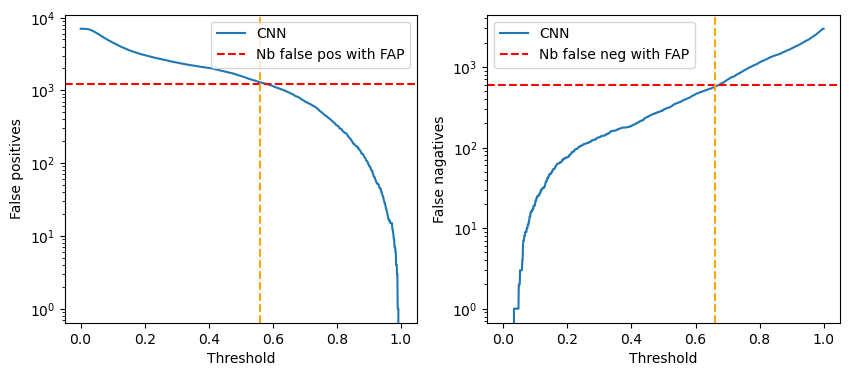

In [108]:
"""
f = np.polyfit(threshold1, False_pos, 20)
p = np.poly1d(f)
y = p(threshold)
"""

plt.figure()
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.plot(threshold, False_pos, label='CNN'), plt.legend()
x_pos = 0.56
plt.axhline(y=false_pos_fap, color='r', linestyle='--',label='Nb false pos with FAP'),plt.legend()
plt.axvline(x=x_pos, color='orange', linestyle='--')
plt.yscale('log')
plt.xlabel("Threshold")
plt.ylabel("False positives")

plt.subplot(122)
plt.plot(threshold, False_neg, label='CNN'),plt.legend()
plt.axhline(y=false_neg_fap, color='r', linestyle='--', label='Nb false neg with FAP'),plt.legend()
x_neg = 0.66
plt.axvline(x=x_neg, color='orange', linestyle='--')
plt.yscale('log')
plt.xlabel("Threshold")
plt.ylabel("False nagatives")

print("Range of possible threshold to use in CNN for better performance : [",x_pos,",",x_neg,"]")

In [109]:
#Comparaison beetwen CNN with founded threshold and FAP with p_value 0.05
opt_threshold = x_neg
y_seuil_cnn = np.where(y_pred_cnn1 > opt_threshold,1,0)
p1 ,r1,f1,m1 = evaluate(y_seuil_cnn,label_test)

y_seuil_fap = np.where(y_pred_FAP < threshold_fap ,1,0)
p2,r2,f2,m2 = evaluate(y_seuil_fap,label_test)

print("CNN Method")
print("Confusion matrix :\n", m1)
print("Precision = ", round(p1,3), ",Recall = ",round(r1,3))
print("\nFAP Method")
print("Confusion matrix :\n", m2)
print("Precision = ", round(p2,3), ",Recall = ",round(r2,3))

CNN Method
Confusion matrix :
 [[6132  892]
 [ 564 2412]]
Precision =  0.73 ,Recall =  0.81

FAP Method
Confusion matrix :
 [[5805 1219]
 [ 595 2381]]
Precision =  0.661 ,Recall =  0.8


In [110]:
N = 10
precision_cnn, precision_fap = np.zeros(N-1), np.zeros(N-1)
recall_cnn, recall_fap = np.zeros(N-1), np.zeros(N-1)

for i in range(1,N):
    ind = np.where( np.logical_and( X2_test[:,0,0] > 0.01*i, X2_test[:,0,0] < 0.01*(i+1)))[0]
    print("Between ", 0.01*i, " and ", 0.01*(i+1), " shape = ", ind.shape)
    y_pred_cnn = model.predict( x = [ tf.gather(X1_test, ind) , tf.gather(X2_test, ind ) ] )
    y_pred_fap = predict_FAP( tf.gather(X2_test, ind ), pdf_mean)
    
    y_seuil_cnn = np.where(y_pred_cnn > opt_threshold,1,0)
    y_seuil_fap = np.where(y_pred_fap < threshold_fap ,1,0)
    
    precision_cnn[i-1], recall_cnn[i-1], f,m = evaluate(y_seuil_cnn,tf.gather(label_test,indices=ind))
    precision_fap[i-1], recall_fap[i-1], f,m = evaluate(y_seuil_fap,tf.gather(label_test,indices=ind))

Between  0.01  and  0.02  shape =  (2048,)
64/64 [==============================] - 3s 43ms/step
Between  0.02  and  0.03  shape =  (1122,)
36/36 [==============================] - 2s 50ms/step
Between  0.03  and  0.04  shape =  (731,)
23/23 [==============================] - 1s 55ms/step
Between  0.04  and  0.05  shape =  (474,)
15/15 [==============================] - 1s 41ms/step
Between  0.05  and  0.06  shape =  (347,)
11/11 [==============================] - 0s 38ms/step
Between  0.06  and  0.07  shape =  (279,)
9/9 [==============================] - 0s 44ms/step
Between  0.07  and  0.08  shape =  (250,)
8/8 [==============================] - 0s 43ms/step
Between  0.08  and  0.09  shape =  (199,)
7/7 [==============================] - 0s 36ms/step
Between  0.09  and  0.1  shape =  (178,)
6/6 [==============================] - 0s 45ms/step


Text(0, 0.5, 'Recall')

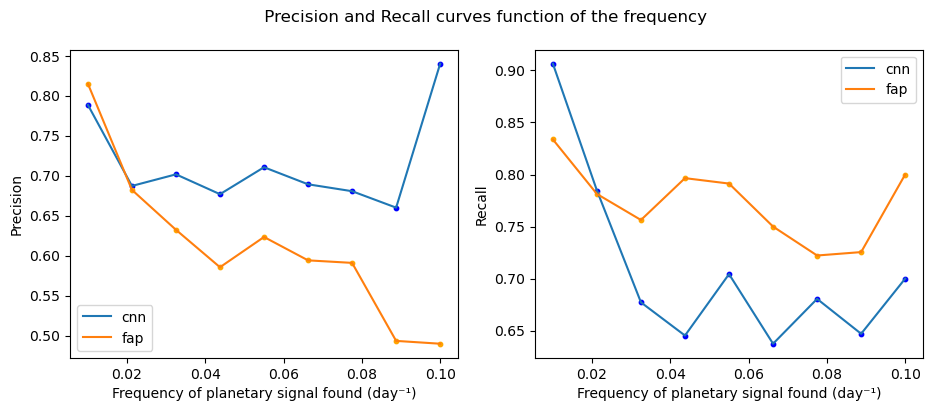

In [111]:
x = np.linspace(0.01, 0.1, N-1)
plt.figure(figsize=(11,4))
plt.suptitle(" Precision and Recall curves function of the frequency")
plt.subplot(121)
plt.scatter(x,precision_cnn, c='b', s=10),plt.plot(x,precision_cnn, label ='cnn'),plt.legend()
plt.scatter(x,precision_fap, c='orange', s=10),plt.plot(x,precision_fap,label ='fap'),plt.legend()
plt.xlabel('Frequency of planetary signal found (day⁻¹)')
plt.ylabel('Precision')
plt.subplot(122)
plt.scatter(x,recall_cnn, c='b', s=10), plt.plot(x,recall_cnn, label ='cnn'),plt.legend()
plt.scatter(x,recall_fap, c='orange', s=10), plt.plot(x,recall_fap,label ='fap'),plt.legend()
plt.xlabel('Frequency of planetary signal found (day⁻¹)')
plt.ylabel('Recall')

 Prot = [5 ; 90] ; P_pl = [10 ; 100] 

Text(0, 0.5, 'Recall')

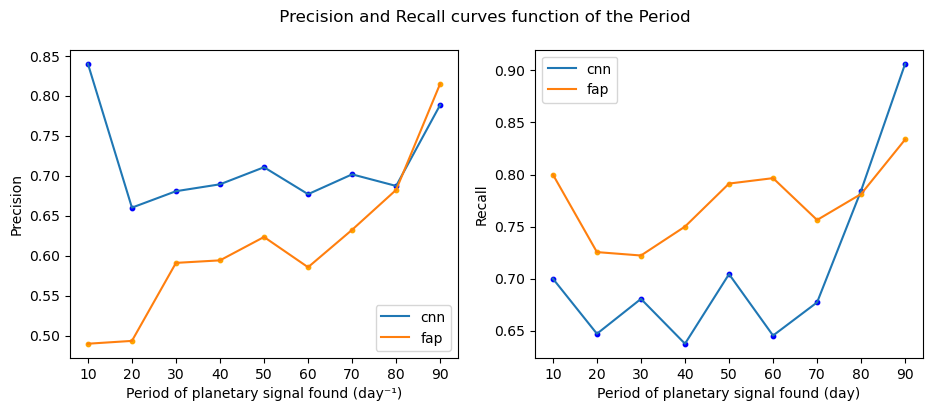

In [112]:
x = np.linspace(10, 90, N-1)
plt.figure(figsize=(11,4))
plt.suptitle(" Precision and Recall curves function of the Period")
plt.subplot(121)
plt.scatter(x,np.flip(precision_cnn), c='b', s=10),plt.plot(x,np.flip(precision_cnn), label ='cnn'),plt.legend()
plt.scatter(x,np.flip(precision_fap), c='orange', s=10),plt.plot(x,np.flip(precision_fap),label ='fap'),plt.legend()
plt.xlabel('Period of planetary signal found (day⁻¹)')
plt.ylabel('Precision')
plt.subplot(122)
plt.scatter(x,np.flip(recall_cnn), c='b', s=10), plt.plot(x,np.flip(recall_cnn), label ='cnn'),plt.legend()
plt.scatter(x,np.flip(recall_fap), c='orange', s=10), plt.plot(x,np.flip(recall_fap),label ='fap'),plt.legend()
plt.xlabel('Period of planetary signal found (day)')
plt.ylabel('Recall')

# Dataset 3, fixed parameters for GP

In [78]:
X_LS = np.load('./data/set3/X_LS.npy',allow_pickle = True)
X_max_values = np.load('./data/set3/X_max_values.npy',allow_pickle = True)
Y = np.load('./data/set3/Y.npy',allow_pickle = True)

In [79]:
#Data pre-processing 
#shuffle
c = list(zip(X_LS, X_max_values,Y))
random.shuffle(c)
X_LS, X_max_values,Y = zip(*c)
#Periodogramme
X_shape =  [N_data,len(X_LS[0]), 1]
X1_tensor = tf.convert_to_tensor(X_LS, dtype = 'float32')
X1 = tf.reshape(X1_tensor, X_shape )
#Max values
X2_tensor = tf.convert_to_tensor(X_max_values, dtype = 'float32')
X2 = tf.reshape(X2_tensor, (N_data, 2,1))
#Label
Y_tensor = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.reshape(Y_tensor, (N_data,1 ))
#Split train/validation
pourcentage = 0.8
split = round(pourcentage * N_data)
X_train12, X_val12 = X1[0:split, :, :], X1[split:, :, :]
X_train22,X_val22 = X2[0:split, :, :], X2[split:, :, :]
Y_train2, Y_val2 = Y[0:split], Y[split:,:]
print("Periodogramme train size : ", X_train12.shape)
print("Periodogramme validation size : ", X_val12.shape,"\n")
print("Max_values train size : ", X_train22.shape)
print("Max_values validation size : ", X_val22.shape,"\n")
print("Label train size : ", Y_train2.shape)
print("Label validation size : ", Y_val2.shape)

Periodogramme train size :  (10963, 990, 1)
Periodogramme validation size :  (2741, 990, 1) 

Max_values train size :  (10963, 2, 1)
Max_values validation size :  (2741, 2, 1) 

Label train size :  (10963, 1)
Label validation size :  (2741, 1)


In [84]:
#Model with functional API Keras

#periodogramme as input to a CNN
inputs12 = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 32, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,))(inputs12)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(32,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs12 = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs22 = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs22)
outputs22 =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs12, outputs22])

x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dense(32, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs2 = layers.Dense(1,activation = 'sigmoid')(x)

model2 = tf.keras.Model(inputs=[inputs12,inputs22], outputs=outputs2, name ="ExoplANNET2")

In [85]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model2.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model2.evaluate( x = [X_train12, X_train22], y = Y_train2, batch_size = 128)

86/86 [==============================] - 8s 83ms/step - loss: 0.6951 - binary_accuracy: 0.1183 - precision_m: 0.0359 - recall_m: 0.0297 - f_score: 0.0323


In [86]:
#Train the network
start = time.time()
history = model2.fit(x = [X_train12, X_train22], y = Y_train2, batch_size = 128, epochs = 50, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val12,X_val22], Y_val2))                                                      
time_train = time.time() - start

Epoch 1/50
86/86 [==============================] - 18s 191ms/step - loss: 0.6307 - binary_accuracy: 0.7083 - precision_m: 0.9424 - recall_m: 0.4480 - f_score: 0.5888 - val_loss: 0.4523 - val_binary_accuracy: 0.8176 - val_precision_m: 0.9882 - val_recall_m: 0.6526 - val_f_score: 0.7847
Epoch 2/50
86/86 [==============================] - 16s 191ms/step - loss: 0.3403 - binary_accuracy: 0.8615 - precision_m: 0.9367 - recall_m: 0.7766 - f_score: 0.8455 - val_loss: 0.2737 - val_binary_accuracy: 0.8942 - val_precision_m: 0.9383 - val_recall_m: 0.8482 - val_f_score: 0.8901
Epoch 3/50
86/86 [==============================] - 16s 187ms/step - loss: 0.2679 - binary_accuracy: 0.8891 - precision_m: 0.9288 - recall_m: 0.8446 - f_score: 0.8830 - val_loss: 0.2539 - val_binary_accuracy: 0.9008 - val_precision_m: 0.9549 - val_recall_m: 0.8442 - val_f_score: 0.8954
Epoch 4/50
86/86 [==============================] - 16s 191ms/step - loss: 0.2492 - binary_accuracy: 0.8994 - precision_m: 0.9311 - recall_

Temps d'entrainement :  422.5670793056488 s


Text(0.5, 0, 'Epochs')

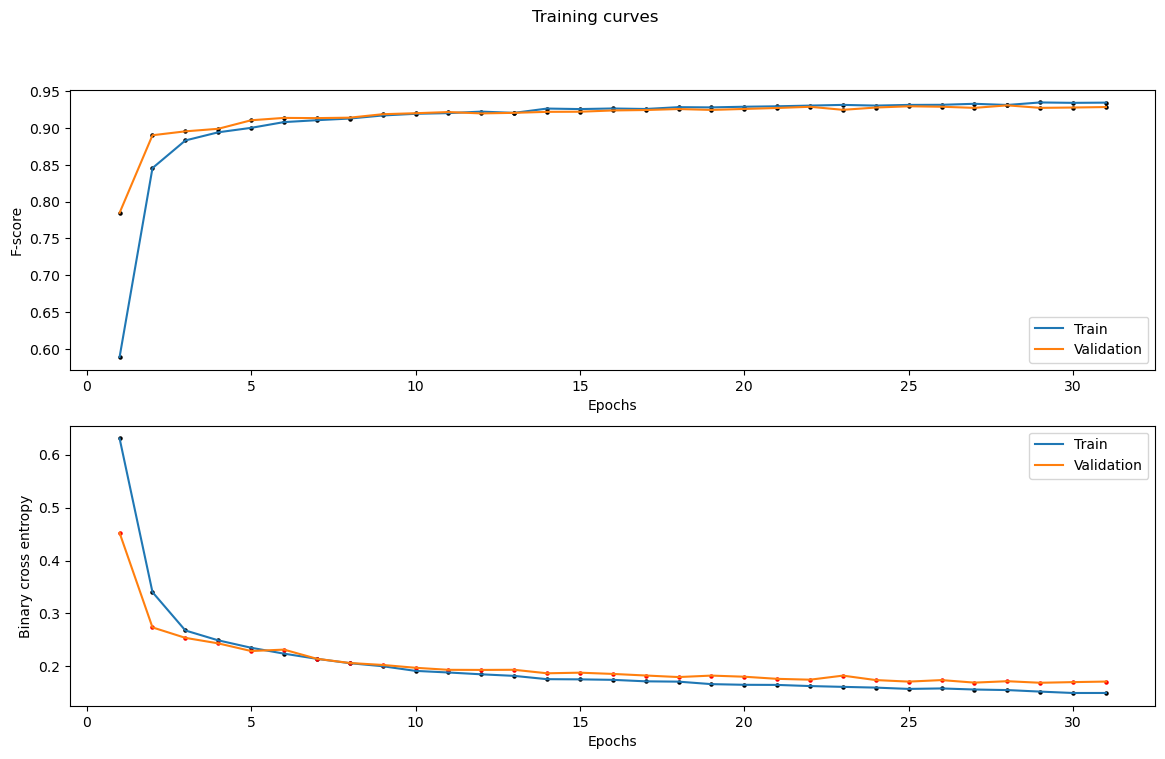

In [87]:
print("Temps d'entrainement : ", time_train, "s")
x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [89]:
# Load dataset for testing
X_LS_test = np.load('./data/set4/X_LS.npy', allow_pickle=True)
X_max_values_test = np.load('./data/set4/X_max_values.npy', allow_pickle=True)
Y_test = np.load('./data/set4/Y.npy', allow_pickle=True)

#shuffle
c = list(zip(X_LS_test, X_max_values_test,Y_test))
random.shuffle(c)
X_LS_test, X_max_values_test,Y_test = zip(*c)

#Periodogramme
X1_test_tensor = tf.convert_to_tensor(X_LS_test, dtype= 'float32')
X1_test_shape =  [len(X_LS_test),len(X_LS_test[0]), 1]
X12_test = tf.reshape(X1_test_tensor, X1_test_shape )
#Max values
X2_test_tensor = tf.convert_to_tensor(X_max_values_test, dtype= 'float32')
X22_test = tf.reshape(X2_test_tensor, (len(X_max_values_test), len(X_max_values_test[0]),1))
#Label
Y_test_tensor = tf.convert_to_tensor(Y_test)
label_test2 = tf.reshape(Y_test_tensor, (len(Y_test),1 ))

print("X1_test shape : ", X12_test.shape)
print("X2_test shape : ", X22_test.shape)
print("label_test shape : ", label_test2.shape)

X1_test shape :  (10000, 990, 1)
X2_test shape :  (10000, 2, 1)
label_test shape :  (10000, 1)


In [90]:
#Evaluation with samples from dataset2
y_pred_cnn2 = model2.predict( x =[X12_test, X22_test])

313/313 [==============================] - 15s 47ms/step


/tmp/ipykernel_24414/2814494810.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_24414/2814494810.py:37: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN1 =  0.77  with threshold =  0.669
Confusion matrix : 
 [[6182  842]
 [ 587 2389]]
AUC =  0.851

Best F-score achieve by FAP =  0.728  with threshold =  0.372
Confusion matrix : 
 [[5947 1077]
 [ 654 2322]]
AUC =  0.822

Best F-score achieve by CNN2 =  0.917  with threshold =  0.777
Confusion matrix : 
 [[6755  209]
 [ 287 2749]]
AUC =  0.976


<Figure size 640x480 with 0 Axes>

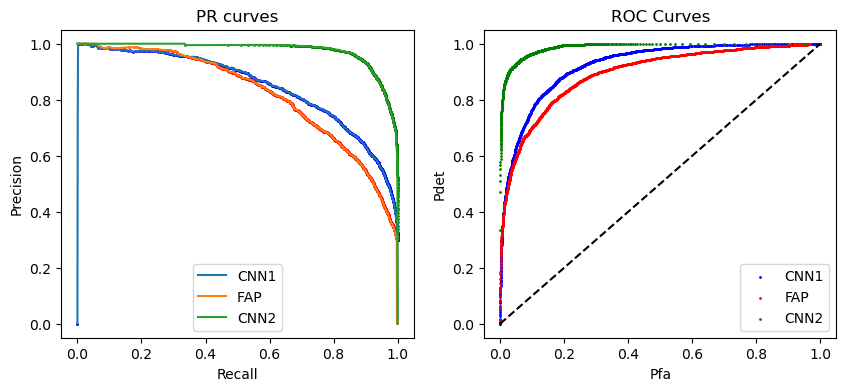

In [114]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)

P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)
P3, R3 = np.zeros(N), np.zeros(N)
Pdet3, Pfa3 = np.zeros(N), np.zeros(N)

best_score_fap = 0
best_score_cnn1 = 0
best_score_cnn2 = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn1) : best_score_cnn1, best_threshold_cnn1, best_m_cnn1 = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m 
        
    y_seuil = np.where(y_pred_cnn2 > threshold[i],1,0)
    P3[i] ,R3[i],f,m = evaluate(y_seuil,label_test2)
    Pdet3[i], Pfa3[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn2) : best_score_cnn2, best_threshold_cnn2, best_m_cnn2 = f, threshold[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))
f3 = interpolate.interp1d(R3, P3,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)
auc3 = integrate.quad(f3, 0, 1)


plt.figure()
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1,P1, s = 1, c ='b')
plt.plot(x_interp,f1(x_interp),label='CNN1'),plt.legend()
plt.scatter(R2,P2,s = 1, c ='r'), 
plt.plot(x_interp,f2(x_interp),label='FAP '),plt.legend()
plt.scatter(R3,P3,s = 1, c ='g')
plt.plot(x_interp,f3(x_interp),label='CNN2'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")


plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1, label='CNN1', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label='FAP', s=1, c='r'),plt.legend()
plt.scatter(Pfa3, Pdet3, label='CNN2', s=1, c='g'),plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")


print("\nBest F-score achieve by CNN1 = ", round(best_score_cnn1,3), " with threshold = ",round(best_threshold_cnn1,3) )
print("Confusion matrix : \n", best_m_cnn1)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))
print("\nBest F-score achieve by CNN2 = ", round(best_score_cnn2,3), " with threshold = ",round(best_threshold_cnn2,3) )
print("Confusion matrix : \n", best_m_cnn2)
print("AUC = ", round(auc3[0],3))

# P-val for each frequency

In [115]:
pdfs = np.load('./data/set1/pdfs.npy', allow_pickle=True)

Text(0.5, 0, 'Amplitude')

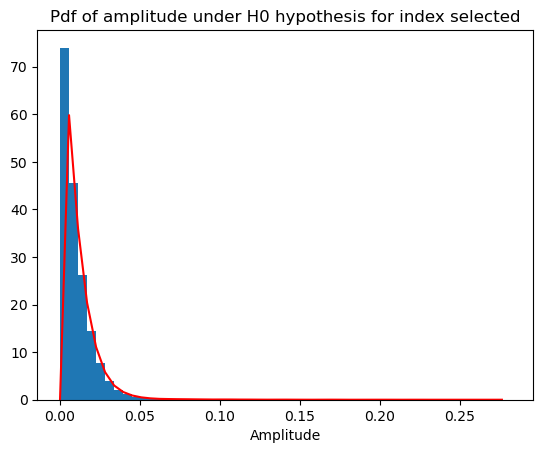

In [118]:
ind = 200
mean_bin = np.zeros(pdfs[0][1].shape[0]-1)
for i in range(pdfs[0][1].shape[0]-1) : mean_bin[i] = (pdfs[ind][1][i+1] + pdfs[ind][1][i])/2
f_pdfs = interpolate.interp1d(mean_bin, pdfs[ind][0],bounds_error = False, fill_value = (0,0))

plt.title("Pdf of amplitude under H0 hypothesis for index selected")
plt.bar(pdfs[ind][1][:-1], pdfs[ind][0], width=np.diff(pdfs[ind][1]), align='edge')
plt.plot(pdfs[ind][1][:-1], f_pdfs(pdfs[ind][1][:-1]), c ='r')
plt.xlabel("Amplitude")

In [119]:
# Function to compute the p-value of a distribution
def predict_pval(GLS, pdfs):
    s = time.time()
    N_test = GLS.shape[0]
    p_vals = np.zeros(N_test)
    ind = np.zeros(N_test)
    
    for i in range(N_test):
        p_val_min = 100
        for k in range(pdfs.shape[0]):
            p_val = compute_p_value(pdfs[k],GLS[i][k])[0]
            if (p_val < p_val_min ) : p_val_min, indice = p_val, k
        
        ind[i] = indice
        p_vals[i] = p_val_min
    print("time = ", time.time()- s )  
    return p_vals, ind

In [121]:
y_pred_pvals, ind = predict_pval(X1_test, pdfs) 

time =  7017.408401250839


/tmp/ipykernel_24414/3859326931.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_24414/3859326931.py:47: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i


Best F-score achieve by CNN1 =  0.77  with threshold =  0.669
Confusion matrix : 
 [[6182  842]
 [ 587 2389]]
AUC =  0.851

Best F-score achieve by FAP =  0.728  with threshold =  0.372
Confusion matrix : 
 [[5947 1077]
 [ 654 2322]]
AUC =  0.822

Best F-score achieve by CNN2 =  0.917  with threshold =  0.777
Confusion matrix : 
 [[6755  209]
 [ 287 2749]]
AUC =  0.976

Best F-score achieve by Pvals =  0.459  with threshold =  0.034
Confusion matrix : 
 [[   2 7022]
 [   1 2975]]
AUC =  0.487


<Figure size 640x480 with 0 Axes>

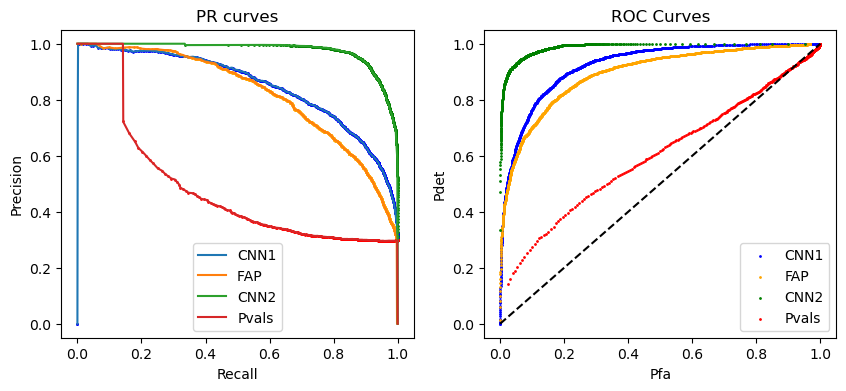

In [122]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
threshold2 = np.linspace(0.0001,max(y_pred_pvals),N)

P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)
P3, R3 = np.zeros(N), np.zeros(N)
Pdet3, Pfa3 = np.zeros(N), np.zeros(N)
P4, R4 = np.zeros(N), np.zeros(N)
Pdet4, Pfa4 = np.zeros(N), np.zeros(N)

best_score_fap = 0
best_score_cnn1 = 0
best_score_cnn2 = 0
best_score_pvals = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn1) : best_score_cnn1, best_threshold_cnn1, best_m_cnn1 = f, threshold[i], m
         
    y_seuil = np.where(y_pred_FAP < threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_fap) : best_score_fap, best_threshold_fap, best_m_fap = f, threshold[i], m 
        
    y_seuil = np.where(y_pred_cnn2 > threshold[i],1,0)
    P3[i] ,R3[i],f,m = evaluate(y_seuil,label_test2)
    Pdet3[i], Pfa3[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn2) : best_score_cnn2, best_threshold_cnn2, best_m_cnn2 = f, threshold[i], m
    
    y_seuil = np.where(y_pred_pvals < threshold2[i],1,0)
    P4[i] ,R4[i],f,m = evaluate(y_seuil,label_test)
    Pdet4[i], Pfa4[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_pvals) : best_score_pvals, best_threshold_pvals, best_m_pvals = f, threshold2[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))
f3 = interpolate.interp1d(R3, P3,bounds_error = False, fill_value = (1,0))
f4 = interpolate.interp1d(R4, P4,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)
auc3 = integrate.quad(f3, 0, 1)
auc4 = integrate.quad(f4, 0, 1)

plt.figure()
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1,P1, s = 1, c ='b')
plt.plot(x_interp,f1(x_interp),label='CNN1'),plt.legend()
plt.scatter(R2,P2,s = 1, c ='orange'), 
plt.plot(x_interp,f2(x_interp),label='FAP '),plt.legend()
plt.scatter(R3,P3,s = 1, c ='g')
plt.plot(x_interp,f3(x_interp),label='CNN2'),plt.legend()
plt.scatter(R4,P4,s = 1, c ='r')
plt.plot(x_interp,f4(x_interp),label='Pvals'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")


plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1, label='CNN1', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label='FAP', s=1, c='orange'),plt.legend()
plt.scatter(Pfa3, Pdet3, label='CNN2', s=1, c='g'),plt.legend()
plt.scatter(Pfa4, Pdet4, label='Pvals', s=1, c='r'),plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")


print("\nBest F-score achieve by CNN1 = ", round(best_score_cnn1,3), " with threshold = ",round(best_threshold_cnn1,3) )
print("Confusion matrix : \n", best_m_cnn1)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by FAP = ", round(best_score_fap,3), " with threshold = ",round(best_threshold_fap,3) )
print("Confusion matrix : \n", best_m_fap)
print("AUC = ", round(auc2[0],3))
print("\nBest F-score achieve by CNN2 = ", round(best_score_cnn2,3), " with threshold = ",round(best_threshold_cnn2,3) )
print("Confusion matrix : \n", best_m_cnn2)
print("AUC = ", round(auc3[0],3))
print("\nBest F-score achieve by Pvals = ", round(best_score_pvals,3), " with threshold = ",round(best_threshold_pvals,3) )
print("Confusion matrix : \n", best_m_pvals)
print("AUC = ", round(auc4[0],3))

In [123]:
y_pred_pvals

array([0.0024845 , 0.00331907, 0.0035829 , ..., 0.00057187, 0.        ,
       0.00407564])

# Model with less parameters

In [124]:
#Model with functional API Keras
#periodogramme as input to a CNN
inputs1_b = tf.keras.Input(shape=(990,1))
x1 = layers.Conv1D(filters = 16, kernel_size = 2, strides = 1, padding = 'same',
                   activation='relu', use_bias = True,input_shape= (990,1))(inputs1_b)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(16,6,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(16,8,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
x1 = layers.Conv1D(16,10,padding = 'same', activation='relu')(x1)
x1 = layers.MaxPooling1D(pool_size=2)(x1)
outputs1_b = layers.Flatten()(x1)

#max_values as input to a dense layers 
inputs2_b = tf.keras.Input(shape=(2,1))
x2 = layers.Dense(2, activation = 'relu')(inputs2_b)
outputs2_b =  layers.Flatten()(x2)

#output of the two network concatenate for input as a dense final network
x = layers.concatenate([outputs1_b, outputs2_b])

x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dense(16, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs_b = layers.Dense(1,activation = 'sigmoid')(x)

In [125]:
model_b = tf.keras.Model(inputs=[inputs1_b,inputs2_b], outputs=outputs_b, name ="ExoplANNET_b")
model_b.summary()

Model: "ExoplANNET_b"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 990, 1)]     0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 990, 16)      48          ['input_15[0][0]']               
                                                                                                  
 max_pooling1d_21 (MaxPooling1D  (None, 495, 16)     0           ['conv1d_21[0][0]']              
 )                                                                                                
                                                                                                  
 conv1d_22 (Conv1D)             (None, 495, 16)      1552        ['max_pooling1d_21[0][

In [126]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_f_score', patience = 3, mode = "max",
                                                  restore_best_weights = True, start_from_epoch = 5)

model_b.compile( loss = tf.keras.losses.BinaryCrossentropy(from_logits= False),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-4),
              metrics =[tf.keras.metrics.BinaryAccuracy(),precision_m, recall_m, f_score])

y_before_train = model_b.evaluate( x = [X_train1, X_train2], y = Y_train, batch_size = 128)

86/86 [==============================] - 3s 24ms/step - loss: 0.6931 - binary_accuracy: 0.4868 - precision_m: 0.4929 - recall_m: 0.9686 - f_score: 0.6522


In [127]:
#Train the network
start = time.time()
history = model_b.fit(x = [X_train1, X_train2], y = Y_train, batch_size = 128, epochs = 100, verbose = 1,
                    callbacks=[early_stopping], validation_data = ([X_val1,X_val2], Y_val))                                                      
time_train = time.time() - start

Epoch 1/100
86/86 [==============================] - 11s 112ms/step - loss: 0.6757 - binary_accuracy: 0.5688 - precision_m: 0.5420 - recall_m: 0.9631 - f_score: 0.6908 - val_loss: 0.6219 - val_binary_accuracy: 0.7917 - val_precision_m: 0.7540 - val_recall_m: 0.8647 - val_f_score: 0.8049
Epoch 2/100
86/86 [==============================] - 11s 126ms/step - loss: 0.5345 - binary_accuracy: 0.7606 - precision_m: 0.7735 - recall_m: 0.7478 - f_score: 0.7549 - val_loss: 0.4839 - val_binary_accuracy: 0.7961 - val_precision_m: 0.8362 - val_recall_m: 0.7422 - val_f_score: 0.7848
Epoch 3/100
86/86 [==============================] - 8s 96ms/step - loss: 0.4879 - binary_accuracy: 0.7757 - precision_m: 0.8076 - recall_m: 0.7230 - f_score: 0.7611 - val_loss: 0.4761 - val_binary_accuracy: 0.7972 - val_precision_m: 0.8324 - val_recall_m: 0.7509 - val_f_score: 0.7881
Epoch 4/100
86/86 [==============================] - 8s 98ms/step - loss: 0.4829 - binary_accuracy: 0.7799 - precision_m: 0.8124 - recall_

Temps d'entrainement :  237.52620124816895 s


Text(0.5, 0, 'Epochs')

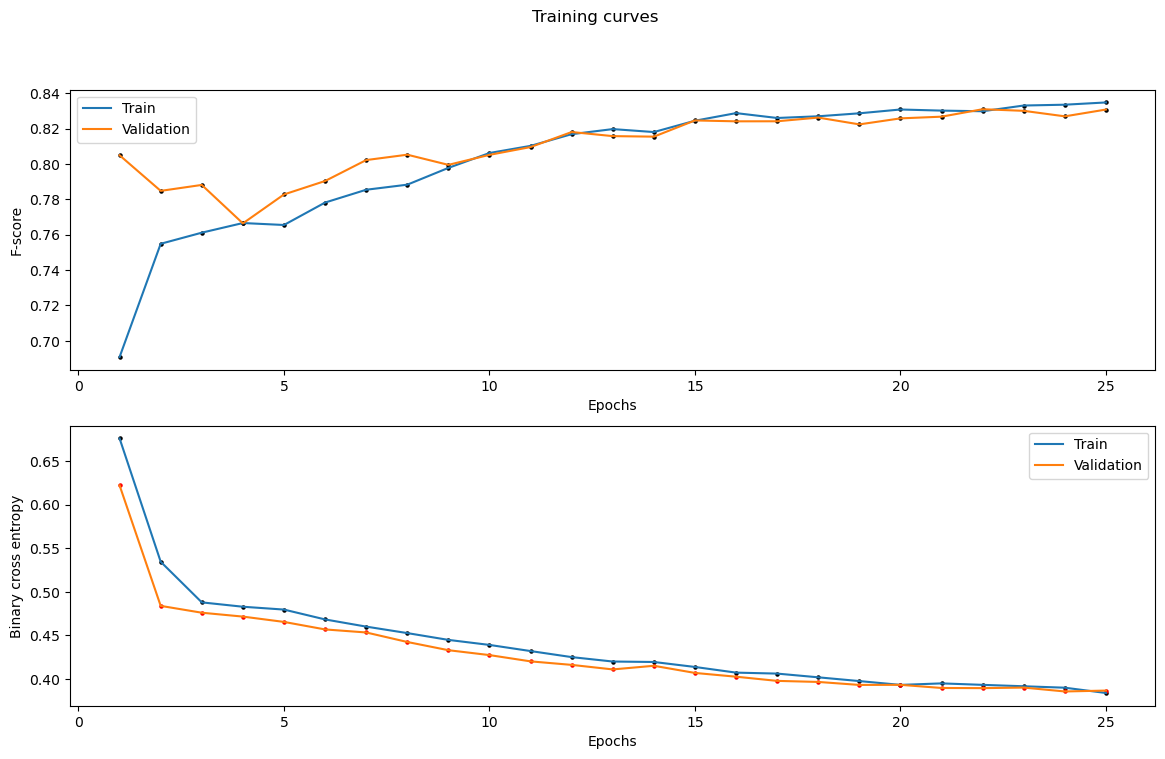

In [128]:
print("Temps d'entrainement : ", time_train, "s")
x = np.arange(1,len(history.history['loss'])+1,1)

plt.figure(figsize=(14,8))
plt.suptitle("Training curves")
plt.subplot(211)
plt.scatter(x,history.history['f_score'], s=5, c='k')
plt.plot(x,history.history['f_score'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_f_score'], s=5, c='k')
plt.plot(x,history.history['val_f_score'], label='Validation'), plt.legend()
plt.ylabel("F-score")
plt.xlabel("Epochs")

plt.subplot(212)
plt.scatter(x,history.history['loss'], s=5, c='k')
plt.plot(x,history.history['loss'], label='Train'), plt.legend()
plt.scatter(x,history.history['val_loss'], s=5, c='r')
plt.plot(x,history.history['val_loss'], label='Validation'), plt.legend()
plt.ylabel("Binary cross entropy")
plt.xlabel("Epochs")

In [129]:
y_pred_cnn1_wlp = model_b.predict( x =[X1_test, X2_test])

313/313 [==============================] - 7s 21ms/step


/tmp/ipykernel_24414/3534951676.py:35: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_24414/3534951676.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i

AUC by CNN1  =  0.851
Best f-score with cnn1 =  0.77  ,with corresponding confusion matrix :
 [[6182  842]
 [ 587 2389]]

AUC by CNN1 with less parameters =  0.852
Best f-score with cnn1 less parameters =  0.768  ,with corresponding confusion matrix :
 [[6029  995]
 [ 502 2474]]


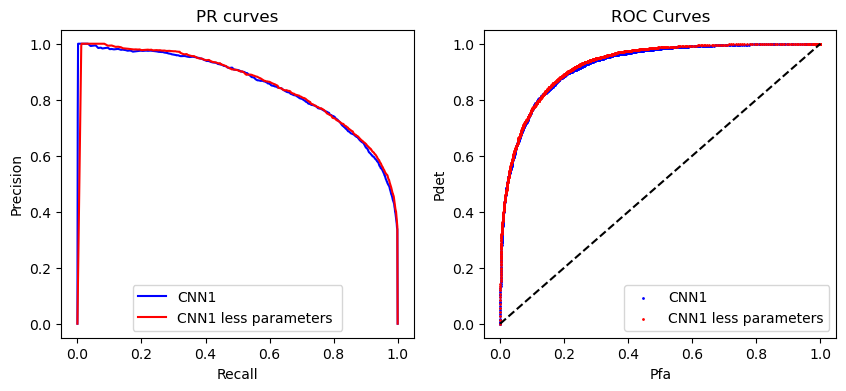

In [130]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)

P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)
P3, R3 = np.zeros(N), np.zeros(N)
Pdet3, Pfa3 = np.zeros(N), np.zeros(N)
best_score_cnn1 = 0
best_score_cnn1_wlp = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn1 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn1) : best_score_cnn1, best_threshold_cnn1, best_m_cnn1 = f, threshold[i], m
         
    y_seuil = np.where(y_pred_cnn1_wlp > threshold[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn1_wlp) : best_score_cnn1_wlp, best_threshold_cnn1_wlp, best_m_cnn1_wlp = f, threshold[i], m 
    
    y_seuil = np.where(np.random.random_sample(label_test.shape[0]) > threshold[i],1,0)
    P3[i] ,R3[i],f,m = evaluate(y_seuil,label_test)
    Pdet3[i], Pfa3[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

f21 = interpolate.interp1d(Pfa1, Pdet1,bounds_error = False, fill_value = (1,0))
f22 = interpolate.interp1d(Pfa2, Pdet2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.plot(x_interp,f1(x_interp),label='CNN1', c='b'),plt.legend()
plt.plot(x_interp,f2(x_interp),label='CNN1 less parameters ',c='r'),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1,label='CNN1',s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2,label='CNN1 less parameters',s=1, c='r'),plt.legend()
#plt.scatter(Pfa3,Pdet3, label='Random', s=1, c='black'), plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")


print("AUC by CNN1  = ", round(auc1[0],3))
print("Best f-score with cnn1 = ", round(best_score_cnn1,3), " ,with corresponding confusion matrix :\n", best_m_cnn1)

print("\nAUC by CNN1 with less parameters = ", round(auc2[0],3))
print("Best f-score with cnn1 less parameters = ", round(best_score_cnn1_wlp,3), " ,with corresponding confusion matrix :\n", best_m_cnn1_wlp)

In [131]:
y_pred_cnn1_wlp

array([[0.03765388],
       [0.20227523],
       [0.78451025],
       ...,
       [0.08102909],
       [0.6437564 ],
       [0.51890075]], dtype=float32)

In [132]:
y_pred_cnn1

array([[0.03199748],
       [0.3056577 ],
       [0.7399189 ],
       ...,
       [0.08479211],
       [0.63202107],
       [0.5287113 ]], dtype=float32)

# Distribution for each frequency with fixed GP parameters

In [133]:
pdfs_fixedGP = np.load('./data/set3/pdfs_fixedGP.npy', allow_pickle=True)

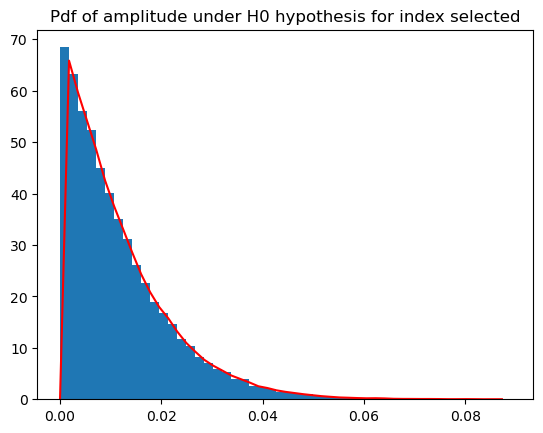

In [134]:
ind = 10
mean_bin = np.zeros(pdfs_fixedGP[0][1].shape[0]-1)
for i in range(pdfs_fixedGP[ind][1].shape[0]-1) : mean_bin[i] = (pdfs_fixedGP[ind][1][i+1] + pdfs_fixedGP[ind][1][i])/2
f_pdfs = interpolate.interp1d(mean_bin, pdfs_fixedGP[ind][0],bounds_error = False, fill_value = (0,0))

plt.title("Pdf of amplitude under H0 hypothesis for index selected")
plt.bar(pdfs_fixedGP[ind][1][:-1], pdfs_fixedGP[ind][0], width=np.diff(pdfs_fixedGP[ind][1]), align='edge')
plt.plot(pdfs_fixedGP[ind][1][:-1], f_pdfs(pdfs_fixedGP[ind][1][:-1]), c ='r')

In [135]:
y_pred_pvals_fixedGP, ind = predict_pval(X12_test, pdfs_fixedGP) 

time =  5264.019560337067



Best F-score achieve by CNN2 =  0.917  with threshold =  0.777
Confusion matrix : 
 [[6755  209]
 [ 287 2749]]
AUC =  0.976

Best F-score achieve by Pvals_fixedGP =  0.459  with threshold =  0.034
Confusion matrix : 
 [[   2 7022]
 [   1 2975]]
AUC =  0.487


/tmp/ipykernel_24414/3848244827.py:28: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc1 = integrate.quad(f1, 0, 1)
/tmp/ipykernel_24414/3848244827.py:29: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose i

<Figure size 640x480 with 0 Axes>

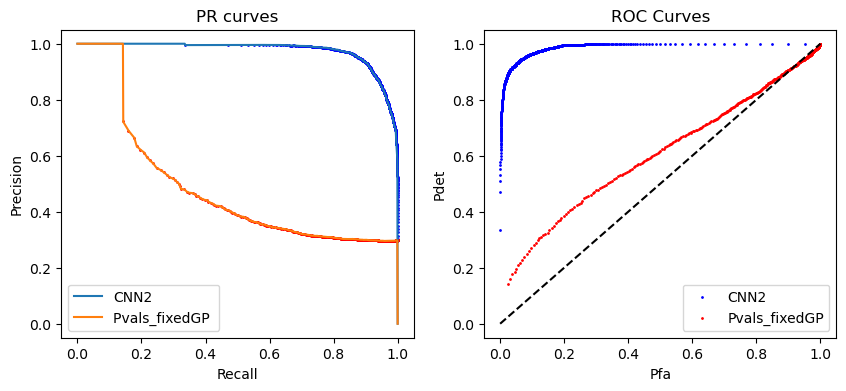

In [136]:
N = 1000
threshold = np.linspace(0.0001,0.9999,N)
threshold2 = np.linspace(0.0001,max(y_pred_pvals_fixedGP),N)

P1, R1 = np.zeros(N), np.zeros(N)
Pdet1, Pfa1 = np.zeros(N), np.zeros(N)
P2, R2 = np.zeros(N), np.zeros(N)
Pdet2, Pfa2 = np.zeros(N), np.zeros(N)

best_score_cnn2 = 0
best_score_pvals_fixedGP = 0

for i in range(N):
    y_seuil = np.where(y_pred_cnn2 > threshold[i],1,0)
    P1[i] ,R1[i],f,m = evaluate(y_seuil,label_test2)
    Pdet1[i], Pfa1[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_cnn2) : best_score_cnn2, best_threshold_cnn2, best_m_cnn2 = f, threshold[i], m
    
    y_seuil = np.where(y_pred_pvals < threshold2[i],1,0)
    P2[i] ,R2[i],f,m = evaluate(y_seuil,label_test)
    Pdet2[i], Pfa2[i] = m[1,1]/(m[1,1]+m[1,0]), m[0,1]/(m[0,0]+m[0,1])
    if (f > best_score_pvals_fixedGP) : best_score_pvals_fixedGP, best_threshold_pvals_fixedGP, best_m_pvals_fixedGP = f, threshold2[i], m 
        
x_interp = np.linspace(0,1,N)
f1 = interpolate.interp1d(R1, P1,bounds_error = False, fill_value = (1,0))
f2 = interpolate.interp1d(R2, P2,bounds_error = False, fill_value = (1,0))

auc1 = integrate.quad(f1, 0, 1)
auc2 = integrate.quad(f2, 0, 1)

plt.figure()
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title("PR curves")
plt.scatter(R1,P1, s = 1, c ='b')
plt.plot(x_interp,f1(x_interp),label='CNN2'),plt.legend()
plt.scatter(R2,P2,s = 1, c ='r'), 
plt.plot(x_interp,f2(x_interp),label='Pvals_fixedGP '),plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")


plt.subplot(122)
plt.title("ROC Curves")
plt.scatter(Pfa1, Pdet1, label='CNN2', s=1, c='b'),plt.legend()
plt.scatter(Pfa2, Pdet2, label='Pvals_fixedGP', s=1, c='r'),plt.legend()
plt.plot(x_interp,x_interp, '--', c='black')
plt.xlabel("Pfa")
plt.ylabel("Pdet")


print("\nBest F-score achieve by CNN2 = ", round(best_score_cnn2,3), " with threshold = ",round(best_threshold_cnn2,3) )
print("Confusion matrix : \n", best_m_cnn2)
print("AUC = ", round(auc1[0],3))
print("\nBest F-score achieve by Pvals_fixedGP = ", round(best_score_pvals,3), " with threshold = ",round(best_threshold_pvals,3) )
print("Confusion matrix : \n", best_m_pvals)
print("AUC = ", round(auc2[0],3))